Our gj 1132 lyman alpha is fainter than https://iopscience.iop.org/article/10.3847/1538-3881/ab24c2/meta. Why?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
import stistools
from astropy.convolution import convolve, Box1DKernel

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


/home/david/anaconda3/lib/python3.7/site-packages/stsci/tools/nmpfit.py:10: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/lib/python3.7/site-packages/stsci/tools/gfit.py:20: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


(1212, 1218)

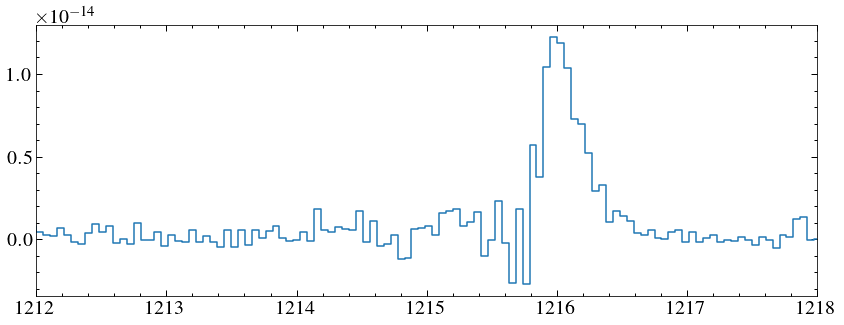

In [4]:
mmdt = Table.read('coadds/GJ1132_g140m_coadd_v1.ecsv')
plt.step(mmdt['WAVELENGTH'], mmdt['FLUX'], where='mid')
plt.xlim(1212, 1218)

Yup, they peak at ~4

In [5]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interpolate.interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid

def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

def no_zero_errors(flux, error):
    """
    Corrects instances where negative flux measurements have very small errors
    """
    e_new = error
    for i in range(len(error)):
        if flux[i] < 0.0 and error[i] < 0.1*abs(flux[i]):
            e_new[i] = abs(flux[i])
    return e_new

def new_coadd(f_array, e_array):
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum(((flux - f_array)**2) * weights, axis=0) / (len(f_array)-1)
    error = (var * rcs)**0.5
    return flux, error

LHS-281 oda002010


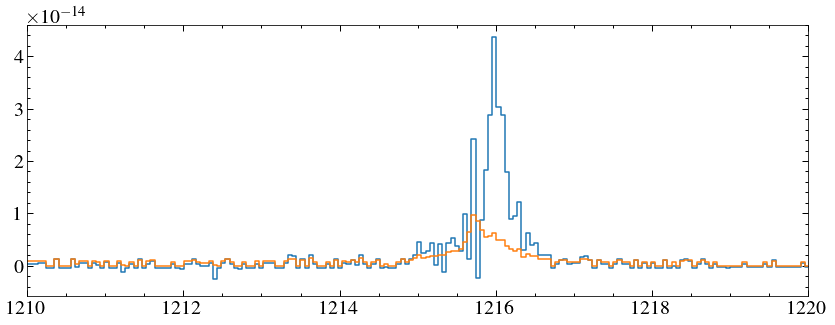

LHS-281 oda001010


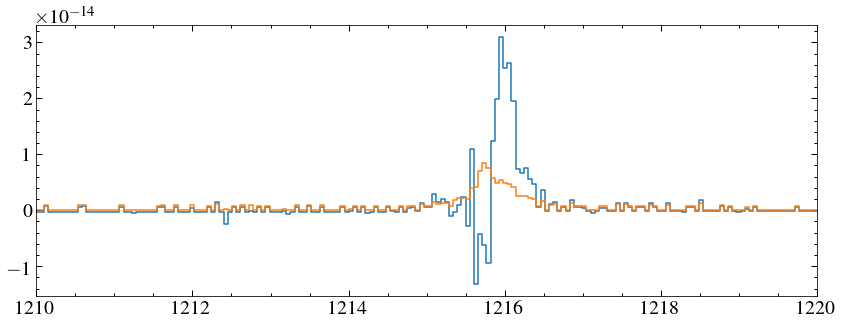

LHS-281 oda001040


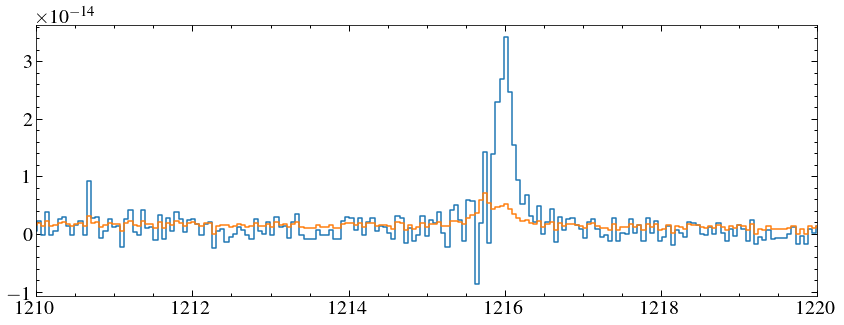

LHS-281 oda003030


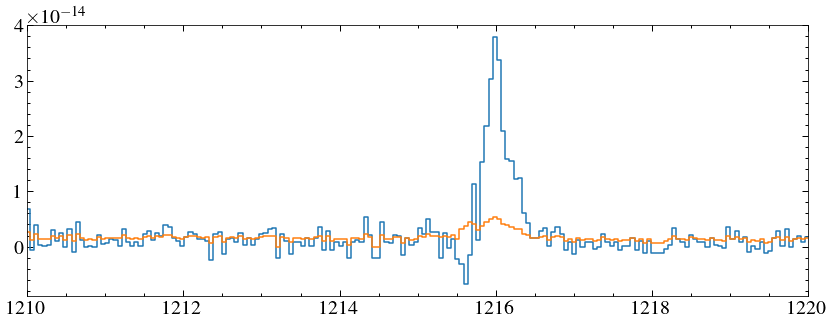

GJ1132 odlm03050


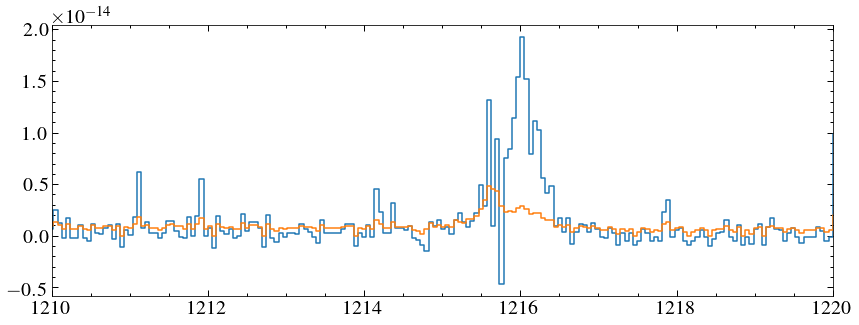

LHS-281 oda003010


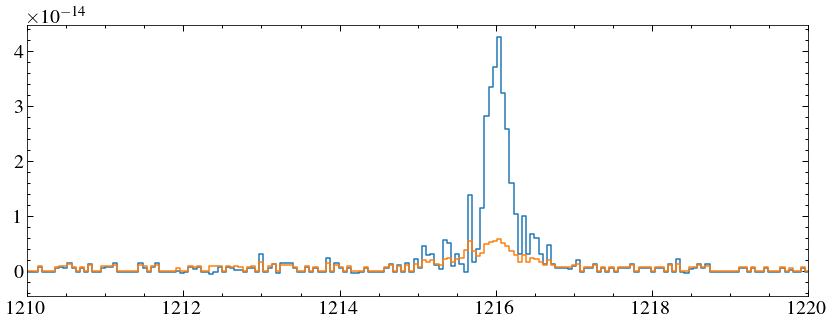

LHS-281 od2r02010


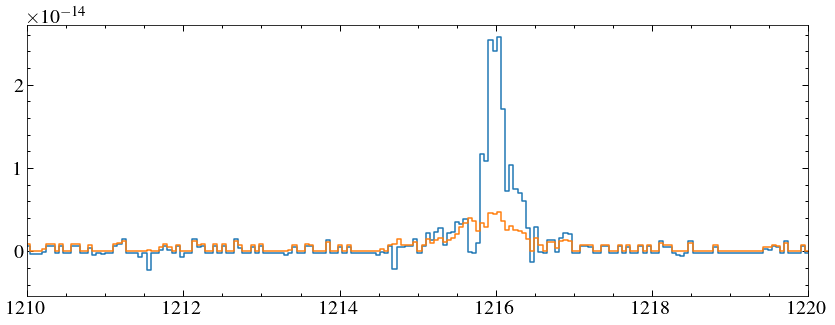

LHS-281 od2r01010


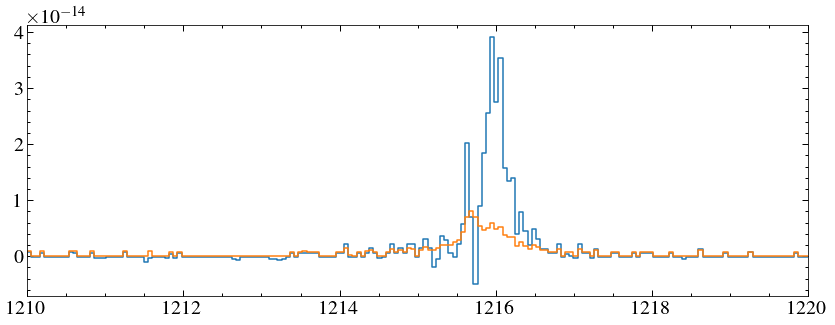

LHS-281 oda002020


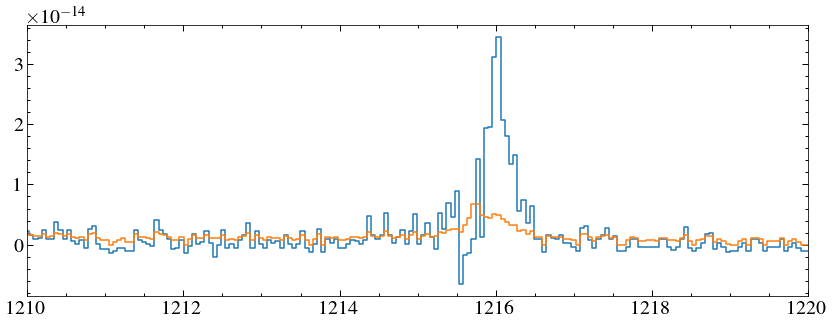

LHS-281 oda004010


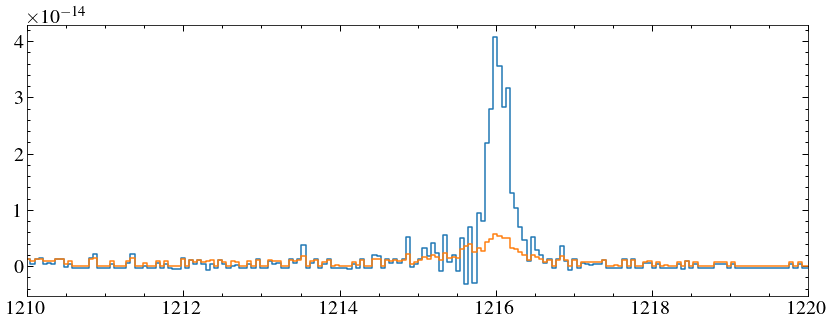

LHS-281 oda003040


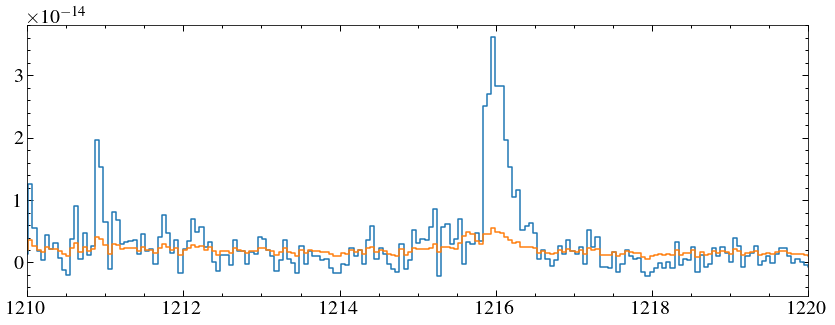

LHS-281 oda004020


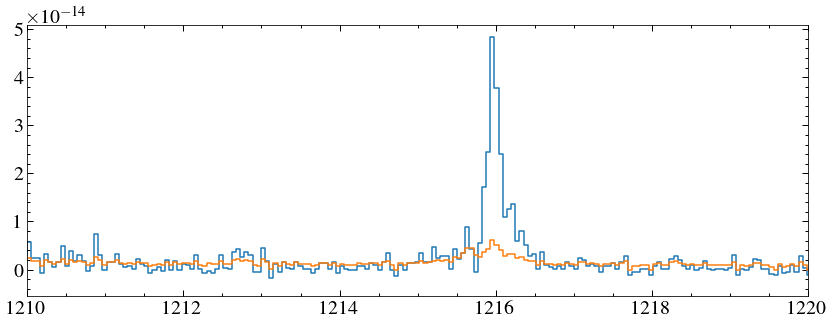

GJ1132 odlm03040


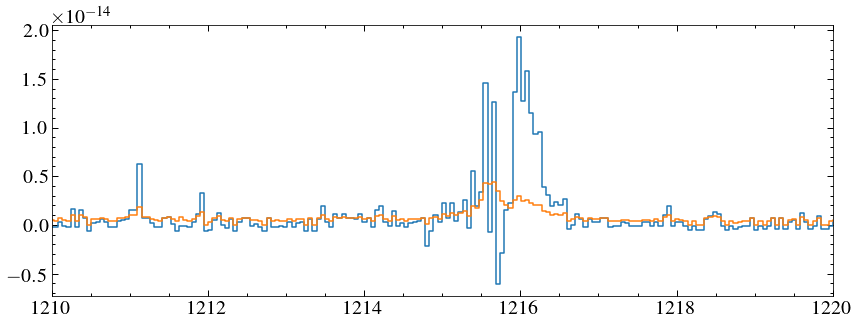

LHS-281 oda001030


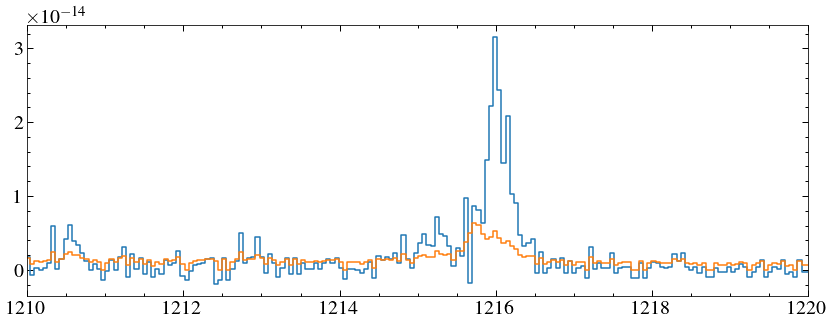

LHS-281 oda003050


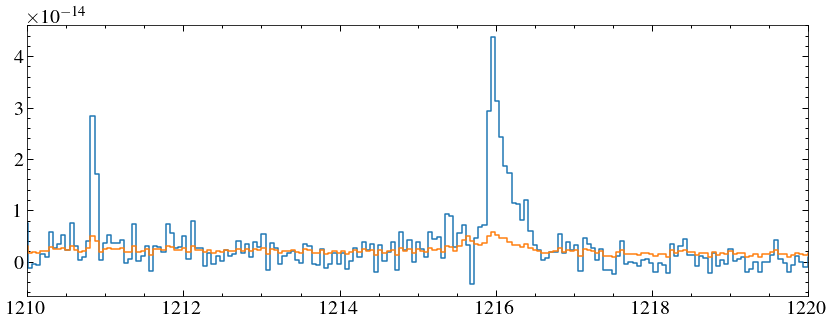

LHS-281 oda003020


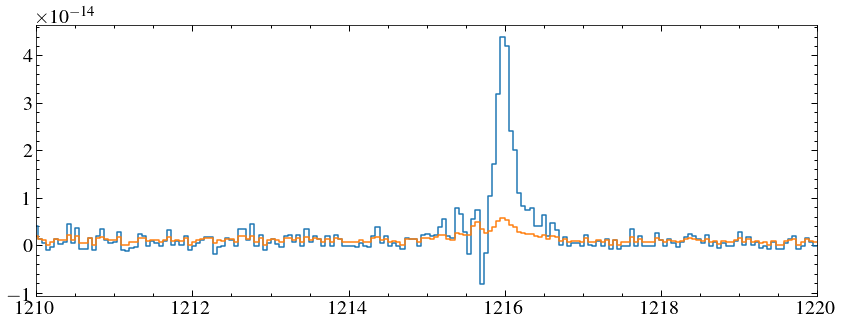

LHS-281 oda001020


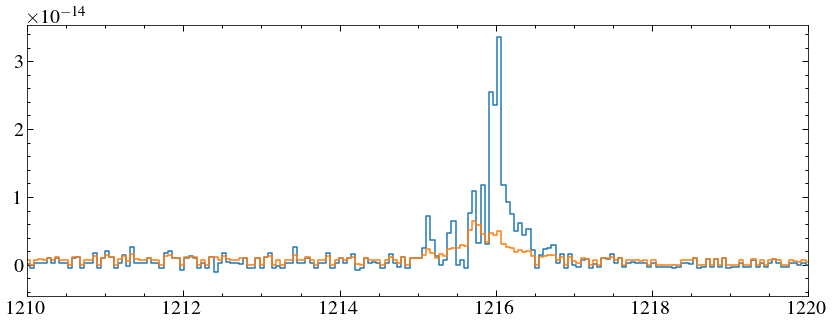

LHS-281 oda001050


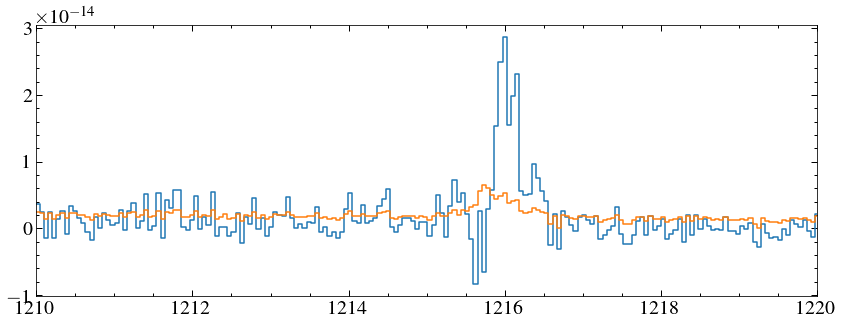

In [9]:
centab = Table.read('gj1132_trace_centers.ecsv')
rdstars = ['GJ1132', 'GJ163', 'L-980-5']
outpath = 'gj1132_extra_extractions/'
flts = glob.glob('data/gj1132_extra/*flt.fits')
#o_roots = ['od3v02010', 'od3v03010', 'od3v01020', 'od3v01010']
for fl in glob.glob(outpath+'*.fits'):
    os.remove(fl)

for flt in flts: 
    hdr = fits.getheader(flt, 0)
    target = hdr['TARGNAME']
   # if target in rdstars:
    rootname = hdr['ROOTNAME']
    SPTRCTAB = hdr['SPTRCTAB']
    grating = hdr['OPT_ELEM']
    cenwave = hdr['CENWAVE']
    tracegrid = build_trace_grid('/home/david/crds_cache/references/hst/oref/'+SPTRCTAB[5:], grating, cenwave)
    rootarg = np.argwhere(centab['ROOTNAME']==rootname)[0][0]
    x = centab['XCOL'][rootarg]
    y = centab['A2CENTER'][rootarg]
    a2center = get_a2center(x,y, tracegrid)#adjust measured a2 center to central point
    stistools.x1d.x1d(flt, output=outpath+rootname+'_new_x1d.fits', verbose=False, 
                      trailer='trl_files/'+rootname+'.trl',a2center=a2center,maxsrch=0)
    x = outpath+rootname+'_new_x1d.fits'
    data = fits.getdata(x, 1)[0]
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    plt.step(wi, fi, where='mid')
    plt.step(wi, ei, where='mid')
    plt.xlim(1210, 1220)
    print(target, rootname)
    plt.show()
     

In [12]:
x1ds = glob.glob(outpath+'*x1d.fits')
times = []
for x in x1ds:
    times.append(fits.getheader(x)['TEXPSTRT'])
times = np.array(times)
x1ds = np.array(x1ds)
args = np.argsort(times)
times, x1ds = times[args], x1ds[args]

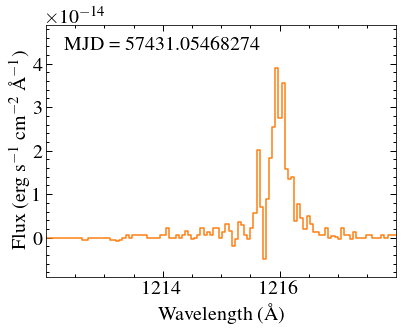

In [53]:
from matplotlib.animation import FuncAnimation




fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
fig.set_tight_layout(True)

ax.set_ylim(-0.9e-14, 4.9e-14)
ax.set_xlim(1212.01, 1217.99)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)')

line1, = ax.step([0,0],[0,0], where='mid', label='_')
note1 = ax.annotate('', (0.05, 0.9), xycoords ='axes fraction' )

def update(i):
    data = fits.getdata(x1ds[i], 1)
    w, f = np.array([], dtype=float), np.array([], dtype=float)
    for dt in data[::-1]:
        wi, fi = dt['WAVELENGTH'], dt['FLUX']
        w = np.concatenate((w, wi))
        f = np.concatenate((f, fi))
    line1.set_xdata(w)
    line1.set_ydata(f)
    #line1.set_label(str(times[i]))
    if times[i] in [58594.37935902, 58594.44553976]:
        line1.set_color('C1')
    note1.set_text('MJD = {}'.format(times[i]))

    return ax, line1, note1

anim = FuncAnimation(fig, update, frames=np.arange(len(x1ds)), interval=300)
anim.save('gj1132_test.gif', dpi=80, writer='imagemagick')
plt.show()

In [51]:
times

array([57431.05468274, 57478.88665155, 57749.08540034, 57749.14528479,
       57749.21165034, 57749.27803923, 57749.34442812, 57750.14763404,
       57750.20605997, 57843.13368971, 57843.19688415, 57845.18591193,
       57845.24909489, 57845.3152986 , 57845.3815023 , 57845.44768304,
       58594.37935902, 58594.44553976])